# Лабораторная работа №2

## Задание 1

### 1.	 Постройте  таблицу pairplot для визуального анализ данных

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(42)
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from scipy import stats

In [2]:
# Загрузка датасета
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
column_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']
iris_df = pd.read_csv(url, header=None, names=column_names)
species_map = {'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2}
iris_df['target'] = iris_df['species'].map(species_map)
iris_df = iris_df.drop('species', axis=1)

In [3]:
iris_df.head()

,sepal_length,sepal_width,petal_length,petal_width,target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


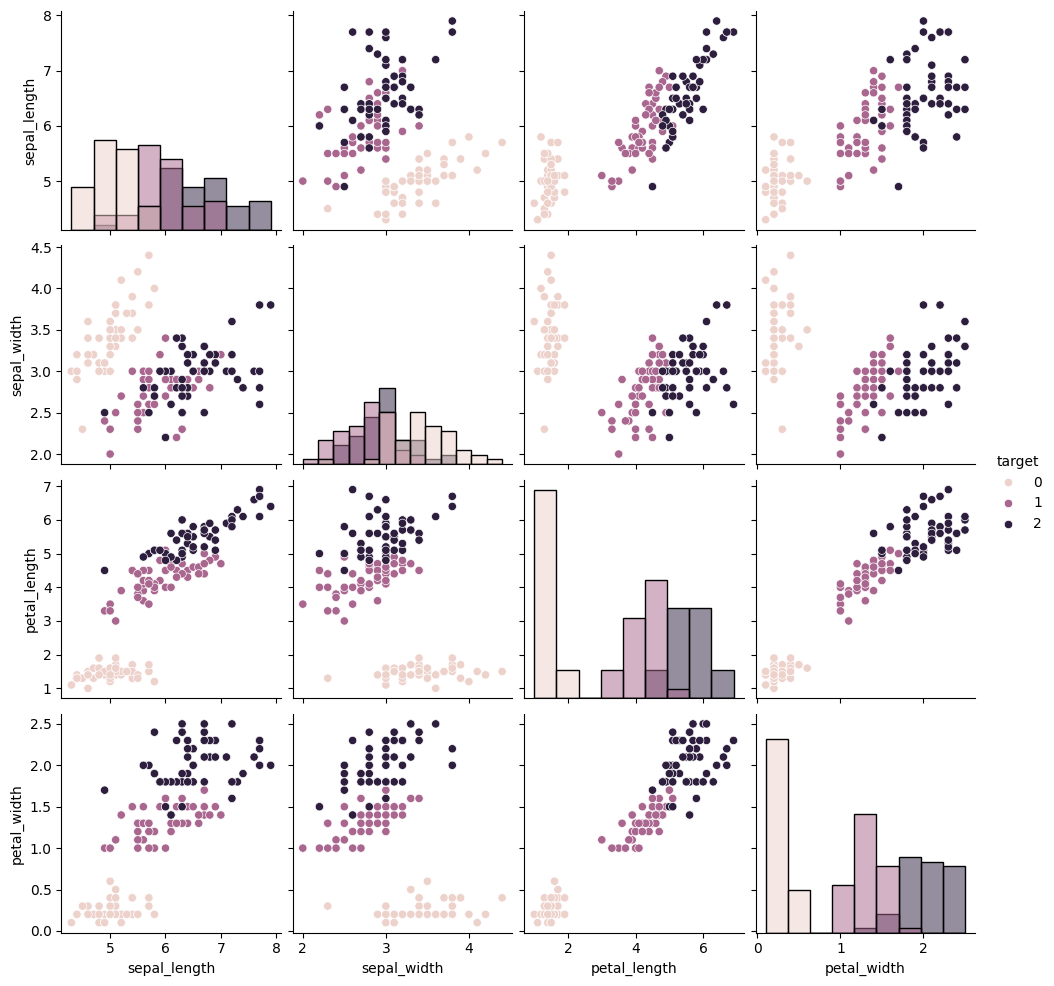

In [4]:
sns.pairplot(iris_df, hue='target', diag_kind='hist')
plt.show()

### 2.	Постройте LogisticRegression для бинарной классификации элементов датасета, на примере данных

In [5]:
# Оставляем только два класса для бинарной классификации (0 и 1)
binary_iris = iris_df[iris_df['target'].isin([0, 1])]

# Разделяем признаки (X) и целевую переменную (y)
X = binary_iris.drop('target', axis=1)
y = binary_iris['target']

# Разделяем данные на тренировочный и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Создаем и обучаем модель логистической регрессии
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)

# Делаем предсказания на тестовом наборе
y_pred = log_reg.predict(X_test)

# Оцениваем точность модели
accuracy = accuracy_score(y_test, y_pred)
print(f'Точность модели на тестовом наборе: {accuracy:.2f}')

Точность модели на тестовом наборе: 1.00


In [6]:
print("\nКоэффициенты модели:")
for feature, coef in zip(X.columns, log_reg.coef_[0]):
    print(f"{feature}: {coef:.4f}")
print(f"Смещение (intercept): {log_reg.intercept_[0]:.4f}")


Коэффициенты модели:
sepal_length: 0.4580
sepal_width: -0.8320
petal_length: 2.2192
petal_width: 0.9305
Смещение (intercept): -6.5636


Точность 1.00 (100%) ожидаема, так как классы в датасете Iris хорошо разделимы.
Коэффициенты показывают, как каждый признак влияет на вероятность принадлежности к классу 1.

### 3. Покажите переобучение модели линейной регрессии и предложите способ борьбы с ним

In [7]:
# Для демонстрации переобучения возьмем один признак и создадим полином высокой степени
X_train_single = X_train[['petal_length']].values  # Берем petal_length
X_test_single = X_test[['petal_length']].values

# Создаем полиномиальные признаки (степенью 10) для переобучения
X_train_poly = np.hstack([X_train_single**i for i in range(1, 11)])  # Полином до 10 степени
X_test_poly = np.hstack([X_test_single**i for i in range(1, 11)])

# Переобученная модель LinearRegression с полиномом
overfitted_model = LinearRegression()
overfitted_model.fit(X_train_poly, y_train)
y_pred_overfitted_train = overfitted_model.predict(X_train_poly)
y_pred_overfitted_test = overfitted_model.predict(X_test_poly)

Создадим также регуляризованную модель чтобы исправить переобчение

In [8]:
# Регуляризованная модель (Ridge) для борьбы с переобучением
regularized_model = Ridge(alpha=1.0)
regularized_model.fit(X_train_poly, y_train)
y_pred_regularized_train = regularized_model.predict(X_train_poly)
y_pred_regularized_test = regularized_model.predict(X_test_poly)

Оценим ошибку MSE полученных моделей

In [9]:
from sklearn.metrics import mean_squared_error
print("Ошибка (MSE) на тренировочном наборе:")
print(f"Переобученная модель: {mean_squared_error(y_train, y_pred_overfitted_train):.4f}")
print(f"Регуляризованная модель: {mean_squared_error(y_train, y_pred_regularized_train):.4f}")
print("\nОшибка (MSE) на тестовом наборе:")
print(f"Переобученная модель: {mean_squared_error(y_test, y_pred_overfitted_test):.4f}")
print(f"Регуляризованная модель: {mean_squared_error(y_test, y_pred_regularized_test):.4f}")

Ошибка (MSE) на тренировочном наборе:
Переобученная модель: 0.0000
Регуляризованная модель: 0.0004

Ошибка (MSE) на тестовом наборе:
Переобученная модель: 0.0058
Регуляризованная модель: 0.0011


Для того чтобы исправить переобучение, следует:
1. Использовать регуляризацию (Ridge или Lasso) для ограничения весов модели.
2. Уменьшить сложность модели, например, снижение степени полинома.
3. Увеличить объем данных или использовать кросс-валидацию.

### 4.	Обогатите датасет сгенерированными вами данными. Опишите какой способ вы применяли и приложите код генерации данных.

Объявим функцию для генерации синтетических данных

In [10]:
def generate_synthetic_data(original_data, n_samples):
    # Разделяем признаки и метки исходного датасета
    X_orig = original_data.drop('target', axis=1)
    y_orig = original_data['target']

    # Обучаем простую модель для предсказания меток
    model = LogisticRegression(multi_class='multinomial', max_iter=200)
    model.fit(X_orig, y_orig)

    # Генерируем синтетические признаки
    synthetic_data = []
    for column in X_orig.columns:
        mean = X_orig[column].mean()
        std = X_orig[column].std()
        synthetic = stats.norm.rvs(mean, std, size=n_samples)
        synthetic_data.append(synthetic)

    # Создаем DataFrame с синтетическими признаками
    synthetic_df = pd.DataFrame(np.column_stack(synthetic_data), columns=X_orig.columns)

    # Предсказываем метки для синтетических данных
    synthetic_df['target'] = model.predict(synthetic_df)

    return synthetic_df

Сгенерируем 50 новых синтетических примеров

In [11]:
n_new_samples = 50
synthetic_data = generate_synthetic_data(binary_iris, n_new_samples)

Объединим сгенерированные данные с имеющимися

In [12]:
enriched_iris = pd.concat([binary_iris, synthetic_data], ignore_index=True)

Проверим что получилось:

In [13]:
print(f"Размер исходного датасета: {binary_iris.shape}")
print(f"Размер обогащенного датасета: {enriched_iris.shape}")
print("\nПервые 5 строк синтетических данных:")
print(synthetic_data.head())

Размер исходного датасета: (100, 5)
Размер обогащенного датасета: (150, 5)

Первые 5 строк синтетических данных:
   sepal_length  sepal_width  petal_length  petal_width  target
0      5.789741     3.248282      0.811744     0.926851       0
1      5.382276     2.910679      2.252668     0.981189       0
2      5.886621     2.771747      2.365556     0.399910       0
3      6.448326     3.385193      1.699850     0.916522       0
4      5.320744     3.584815      2.628367     0.950963       0


Описание способа генерации:<br>
Признаки генерируются по нормальному распределению на основе статистики исходных данных, а метки предсказываются логистической регрессией, чтобы сохранить зависимость между признаками и классами.

### 5.	Поэкспериментируйте с возможными AutoML моделями для усовершенствования эталонного решения.

Используем H2O AutoML для автоматизированного подбора моделей и сравним результаты с эталонной логистической регрессией. H2O AutoML протестирует несколько алгоритмов и выберет лучшую модель.

In [14]:
url = 'https://raw.githubusercontent.com/andriygav/MachineLearningSeminars/master/sem1/data/iris.csv'
column_names = ['длина_чашелистика', 'ширина_чашелистика', 'длина_лепестка', 'ширина_лепестка', 'класс']
dataset = pd.read_csv(url, header=None, names=column_names)
species_map = {'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2}
dataset['target'] = dataset['класс'].map(species_map)
dataset = dataset.drop('класс', axis=1)
dataset_reduced = dataset[['длина_чашелистика', 'ширина_чашелистика', 'target']]
n_new_samples = 200
synthetic_data = generate_synthetic_data(dataset_reduced, n_new_samples)
enriched_iris = pd.concat([dataset_reduced, synthetic_data], ignore_index=True)

In [15]:
X = enriched_iris.drop('target', axis=1)
y = enriched_iris['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
log_reg = LogisticRegression(multi_class='multinomial', max_iter=200)
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)
baseline_accuracy = accuracy_score(y_test, y_pred)
baseline_f1 = f1_score(y_test, y_pred, average='weighted')

In [17]:
baseline_accuracy

0.8285714285714286

In [18]:
baseline_f1

0.8319066320203153

#### fedot

In [19]:
from fedot.core.data.data import InputData
from fedot.core.pipelines.pipeline import Pipeline
from fedot.core.pipelines.node import PipelineNode
from fedot.core.repository.tasks import Task, TaskTypesEnum

In [20]:

# Создание InputData с обработкой
train_input = InputData.from_dataframe(
    features_df=X_train,
    target_df=y_train,
    task=Task(TaskTypesEnum.classification)
)


test_input = InputData.from_dataframe(
    features_df=X_test,
    target_df=y_test,
    task=Task(TaskTypesEnum.classification)
)


node_final = PipelineNode(
    'catboost', 
    nodes_from=[
        PipelineNode('scaling'),
        # PipelineNode('pca', params={'n_components': 5})  # Добавление PCA
    ]
)
pipeline = Pipeline(node_final)

# Обучение с параметрами
pipeline.fit(train_input)
print('success fit')

2025-04-19 13:34:46,991 - Topological features operation requires extra dependencies for time series forecasting, which are not installed. It can infuence the performance. Please install it by 'pip install fedot[extra]'
2025-04-19 13:34:47,157 - TableTypesCorrector - Preprocessing was unable to define the categorical columns
success fit


In [21]:
pipeline.print_structure()

Pipeline structure:
{'depth': 2, 'length': 2, 'nodes': [catboost, scaling]}
catboost - {'n_jobs': 1, 'num_trees': 3000, 'learning_rate': 0.03, 'l2_leaf_reg': 0.01, 'bootstrap_type': 'Bernoulli', 'grow_policy': 'SymmetricTree', 'max_depth': 5, 'min_data_in_leaf': 1, 'one_hot_max_size': 10, 'fold_permutation_block': 1, 'boosting_type': 'Plain', 'od_type': 'Iter', 'od_wait': 100, 'max_bin': 32, 'feature_border_type': 'GreedyLogSum', 'nan_mode': 'Min', 'verbose': False, 'allow_writing_files': False, 'use_eval_set': True, 'use_best_model': True, 'enable_categorical': True}
scaling - {}


In [22]:
y_pred_train = pipeline.predict(train_input).predict.argmax(axis=1)

print("\tTrain Metrics:")
print("F1-score:", f1_score(y_train, y_pred_train, average='weighted'))
print("Accuracy:", accuracy_score(y_train, y_pred_train))

	Train Metrics:
F1-score: 0.9320855614973262
Accuracy: 0.9321428571428572


In [23]:
f1_best = 0.
acc_best = 0.

In [24]:
y_pred_test = pipeline.predict(test_input).predict.argmax(axis=1)

print("Test Metrics:")

f1 = f1_score(y_test, y_pred_test, average='weighted')
acc = accuracy_score(y_test, y_pred_test)
if f1 > f1_best:
    f1_best = f1
if acc > acc_best:
    acc_best = acc
print("F1-score:", f1)
print("Accuracy:", acc)

\Test Metrics:
F1-score: 0.8465362372339117
Accuracy: 0.8428571428571429


#### TPOT

In [25]:
from tpot import TPOTClassifier

In [26]:
# Настройка TPOT
tpot = TPOTClassifier(
    generations=10,           # Количество поколений
    population_size=20,      # Размер популяции
    verbosity=2,
    random_state=42,
    # scoring='roc_auc',
    n_jobs=-1,
    max_time_mins=2,
    config_dict='TPOT light'
)

# Обучение
tpot.fit(X_train, y_train)

Version 0.12.2 of tpot is outdated. Version 1.0.0 was released Wednesday February 26, 2025.


Optimization Progress:   0%|          | 0/20 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.9107142857142858

Generation 2 - Current best internal CV score: 0.9107142857142858

Generation 3 - Current best internal CV score: 0.9107142857142858

Generation 4 - Current best internal CV score: 0.9107142857142858

Generation 5 - Current best internal CV score: 0.9107142857142858

Generation 6 - Current best internal CV score: 0.9178571428571429

Generation 7 - Current best internal CV score: 0.9178571428571429

Generation 8 - Current best internal CV score: 0.9178571428571429

Generation 9 - Current best internal CV score: 0.9178571428571429

Generation 10 - Current best internal CV score: 0.9178571428571429

Best pipeline: KNeighborsClassifier(input_matrix, n_neighbors=84, p=2, weights=uniform)


TPOTClassifier(config_dict='TPOT light', generations=10, max_time_mins=2,
               n_jobs=-1, population_size=20, random_state=42, verbosity=2)

In [27]:
best_pipeline = tpot.fitted_pipeline_

# Print the pipeline steps
print(best_pipeline.steps)

[('kneighborsclassifier', KNeighborsClassifier(n_neighbors=84))]


In [122]:
y_pred_train = tpot.predict(X_train)

print("\tTrain Metrics:")
print("F1-score:", f1_score(y_train, y_pred_train, average='weighted'))
print("Accuracy:", accuracy_score(y_train, y_pred_train))

	Train Metrics:
F1-score: 0.9210114433370247
Accuracy: 0.9214285714285714


In [28]:
y_pred_test = tpot.predict(X_test)

print("\tTest Metrics:")

f1 = f1_score(y_test, y_pred_test, average='weighted')
acc = accuracy_score(y_test, y_pred_test)
if f1 > f1_best:
    f1_best = f1
if acc > acc_best:
    acc_best = acc
print("F1-score:", f1)
print("Accuracy:", acc)

	Test Metrics:
F1-score: 0.8050040645188894
Accuracy: 0.8


#### lightautoml

In [30]:
from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task
from lightgbm import LGBMClassifier
import logging

logging.getLogger('lightautoml').setLevel(logging.WARNING)

In [31]:

# train_df[target] = train_df[target].astype(int)

# test_df[target] = test_df[target].astype(int)
train_df = X_train.copy()
train_df['target'] = y_train

test_df = X_test.copy()
test_df['target'] = y_test

task = Task('multiclass')
roles = {
    'target': 'target',
    'drop': []  # Укажите колонки для исключения, если есть
}


automl = TabularAutoML(
    task=task,
    timeout=600,  # 10 минут
    cpu_limit=4,
    general_params={
        'use_algos': [['lgb', 'cb', 'cb_tuned', 'xgb']],  # Только LightGBM и CatBoost
        'default_params': {
            'lgb': {
                'class_weight': 'balanced',  # Учет дисбаланса классов
                'random_state': 42
            },
            'cb': {
                'auto_class_weights': 'Balanced',
                'random_state': 42
            }
        }
    },
    reader_params={
        'cv': 5,
        'random_state': 42
    }
)

train_pred = automl.fit_predict(train_df, roles=roles, verbose=0)

2025-04-19 13:35:14,668 - Stdout logging level is ERROR.
2025-04-19 13:35:14,669 - Copying TaskTimer may affect the parent PipelineTimer, so copy will create new unlimited TaskTimer
2025-04-19 13:35:14,669 - Task: multiclass

2025-04-19 13:35:14,670 - Start automl preset with listed constraints:
2025-04-19 13:35:14,670 - - time: 600.00 seconds
2025-04-19 13:35:14,671 - - CPU: 4 cores
2025-04-19 13:35:14,671 - - memory: 16 GB

2025-04-19 13:35:14,672 - Train data shape: (280, 3)

2025-04-19 13:35:16,962 - Layer 1 train process start. Time left 597.71 secs
2025-04-19 13:35:17,071 - Selector_LightGBM fitting and predicting completed
2025-04-19 13:35:17,076 - Start fitting Lvl_0_Pipe_0_Mod_0_LightGBM ...
2025-04-19 13:35:17,891 - Fitting Lvl_0_Pipe_0_Mod_0_LightGBM finished. score = -0.3532024523554727
2025-04-19 13:35:17,892 - Lvl_0_Pipe_0_Mod_0_LightGBM fitting and predicting completed
2025-04-19 13:35:17,894 - Start fitting Lvl_0_Pipe_0_Mod_1_CatBoost ...
2025-04-19 13:35:18,153 - Fitti

In [32]:
y_pred_train = automl.predict(X_train).data.argmax(axis=1)

print("\tTrain Metrics:")
print("F1-score:", f1_score(y_train, y_pred_train, average='weighted'))
print("Accuracy:", accuracy_score(y_train, y_pred_train))

	Train Metrics:
F1-score: 0.9356814063595978
Accuracy: 0.9357142857142857


In [33]:
y_pred_test = automl.predict(X_test).data.argmax(axis=1)

print("\tTest Metrics:")

f1 = f1_score(y_test, y_pred_test, average='weighted')
acc = accuracy_score(y_test, y_pred_test)
if f1 > f1_best:
    f1_best = f1
if acc > acc_best:
    acc_best = acc
print("F1-score:", f1)
print("Accuracy:", acc)

	Test Metrics:
F1-score: 0.8457482993197278
Accuracy: 0.8428571428571429


In [34]:
print(f"Точность лучшей AutoML модели: {acc_best:.4f}")
print(f"F1-score лучшей AutoML модели: {f1_best:.4f}")

Точность лучшей AutoML модели: 0.8429
F1-score лучшей AutoML модели: 0.8465


Оценим точность эталонной модели

In [35]:
print(f"\nУлучшение точности по сравнению с эталонной моделью: {acc_best - baseline_accuracy:.4f}")
improvement_f1 = f1_best - baseline_f1
print(f"\nУлучшение по F1-score по сравнению с эталонной моделью: {improvement_f1:.4f}")


Улучшение точности по сравнению с эталонной моделью: 0.0143

Улучшение по F1-score по сравнению с эталонной моделью: 0.0146


#### mlflow

In [49]:
import mlflow
from mlflow.pyfunc import PythonModel

class LightAutoMLWrapper(PythonModel):
    def __init__(self, automl):
        self.automl = automl
        
    def predict(self, context, model_input):
        predictions = self.automl.predict(model_input).data
        
        # Convert NumpyDataset to JSON-serializable format
        return np.argmax(predictions, axis=1) #.tolist() #predictions.data[:, 0]

mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("ppa_lab")

/Users/vladimir/miniconda3/envs/py39_jupyter/lib/python3.9/site-packages/mlflow/pyfunc/utils/data_validation.py:186: UserWarning: Add type hints to the `predict` method to enable data validation and automatic signature inference during model logging. Check https://mlflow.org/docs/latest/model/python_model.html#type-hint-usage-in-pythonmodel for more details.
  color_warning(


<Experiment: artifact_location='/Users/vladimir/artifacts/1', creation_time=1745045246605, experiment_id='1', last_update_time=1745045246605, lifecycle_stage='active', name='ppa_lab', tags={}>

In [50]:
# Save to MLflow
lab = 'task1'
with mlflow.start_run(run_name=lab):
    wrapped_model = LightAutoMLWrapper(automl)

    mlflow.pyfunc.log_model(
        artifact_path=lab,
        python_model=wrapped_model,
    )

2025/04/19 13:41:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run task1 at: http://localhost:5000/#/experiments/1/runs/5ca5848c1824447992a1e06b70fa39c7
🧪 View experiment at: http://localhost:5000/#/experiments/1


In [51]:
# проверка корректности выгрузки модели из mlflow
run_id = '5ca5848c1824447992a1e06b70fa39c7'
loaded_model = mlflow.pyfunc.load_model(f"runs:/{run_id}/{lab}")
predictions_mlflow = loaded_model.predict(X_test)

In [52]:
# # сохранение артефактов локально
mlflow.artifacts.download_artifacts(
    run_id=run_id,
    artifact_path=lab, 
    dst_path="./downloaded_model"
)

'/Users/vladimir/Desktop/University/ppa/labs/downloaded_model/task1'

In [55]:
# !mlflow models serve -m "./downloaded_model/task1" --port 1234 --no-conda
# проверка сервиса
!curl http://localhost:1234/ping

In [57]:

import requests

# отправка post запроса к развернутому сервису
response = requests.post(
    "http://localhost:1234/invocations",
    json={"dataframe_records": X_test.to_dict(orient="records")}
)
predictions_mlflow_server = response.json()['predictions']

In [58]:
# Предсказания на тесте оригинальной модели
test_predict = automl.predict(X_test).data.argmax(axis=1)

In [59]:
np.allclose(predictions_mlflow, test_predict)

True

In [60]:
np.allclose(predictions_mlflow_server, test_predict)

True

Сохранение модели в mlflow и ее развертывание с помощью mlflow server прошло корректно, резульаты работы модели совпадают с исходными

## Задание 2

Цель задания: обработка кардиологического дата-сета для решения задач классификации<br>
Загрузим первым шагом датасет

In [61]:
import pandas as pd
from urllib.parse import quote

base_url = "https://raw.githubusercontent.com/AI-is-out-there/data2lab/main/"
filename = "модуль 2 - датасет - практика.csv"
encoded_url = base_url + quote(filename)

df = pd.read_csv(encoded_url)
df.head()

,subject_id,Count_subj,study_id,cart_id,Healthy_Status,eeg_time,eeg_date,report_0,report_1,report_2,...,filtering,rr_interval,p_onset,p_end,qrs_onset,qrs_end,t_end,p_axis,qrs_axis,t_axis
0,19557662,27,40000017,6848296,0,8:44 AM,27.06.2015,Sinus rhythm,Possible right atrial abnormality,NaN,...,60 Hz notch Baseline filter,659,40,128,170,258,518,81,77,79
1,18477137,93,40000029,6848296,0,9:54 AM,27.06.2015,Sinus rhythm,Possible right atrial abnormality,NaN,...,60 Hz notch Baseline filter,722,40,124,162,246,504,77,75,70
2,16598616,3,40000035,6376932,1,9:07 AM,28.06.2015,Sinus tachycardia,NaN,Normal ECG except for rate,...,60 Hz notch Baseline filter,600,40,130,162,244,474,79,72,77
3,16368287,7,40000079,6214760,1,5:14 PM,15.07.2015,Sinus rhythm,NaN,Normal ECG,...,60 Hz notch Baseline filter,659,40,146,180,254,538,79,66,69
4,18370366,2,40000084,6632385,0,1:52 PM,27.09.2015,Sinus rhythm,NaN,NaN,...,<not specified>,659,368,29999,504,590,868,84,80,77


### 1. Визуализируйте с помощью boxplot загруженные данные, опишите ваши мысли по данным.

In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

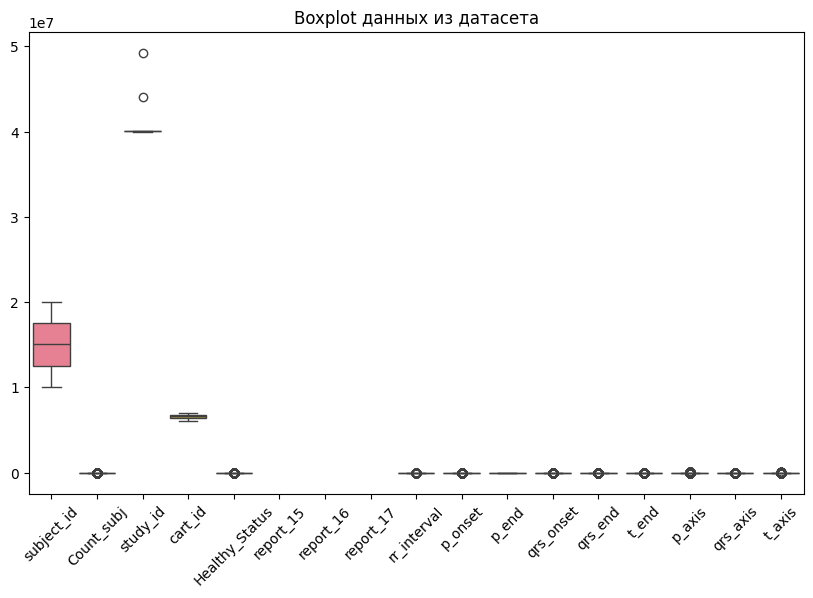

In [63]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df)
plt.title("Boxplot данных из датасета")
plt.xticks(rotation=45)
plt.show()

Датасет содержит медицинские данные об ЭКГ пациентов, включая их состояние здоровья и результаты обследований. boxplot показал сильный разброс значений: есть аномально большие данные, а большинство показателей сосредоточены в узком диапазоне

### 2. Проанализируйте данные и  проведите их предобработку (очистку, обогащение).

Проверим сколько имеем пропусков

In [64]:
print(df.isnull().sum())

subject_id            0
Count_subj            0
study_id              0
cart_id               0
Healthy_Status        0
eeg_time              0
eeg_date              0
report_0              0
report_1           2532
report_2           3532
report_3           5094
report_4           7218
report_5           8519
report_6           9326
report_7           9692
report_8           9886
report_9           9971
report_10          9983
report_11          9991
report_12          9999
report_13          9998
report_14          9999
report_15         10000
report_16         10000
report_17         10000
bandwidth             0
filtering             0
rr_interval           0
p_onset               0
p_end                 0
qrs_onset             0
qrs_end               0
t_end                 0
p_axis                0
qrs_axis              0
t_axis                0
dtype: int64


Обработаем выбросы

In [65]:
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Заменяем выбросы на медиану
    median = df[column].median()
    df[column] = df[column].apply(lambda x: median if x < lower_bound or x > upper_bound else x)
    return df

# Применяем к временным параметрам
time_columns = ['rr_interval', 'p_onset', 'p_end', 'qrs_onset', 'qrs_end', 't_end']
for col in time_columns:
    df = remove_outliers(df, col)

df[time_columns].describe()

,rr_interval,p_onset,p_end,qrs_onset,qrs_end,t_end
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.00000
mean,814.402400,81.359500,8930.689000,199.319300,297.59020,601.00690
std,186.830027,104.654067,13602.948503,23.467033,34.82657,59.89811
min,314.000000,14.000000,0.000000,128.000000,183.00000,408.00000
25%,682.000000,40.000000,144.000000,188.000000,278.00000,566.00000
50%,810.000000,40.000000,158.000000,200.000000,300.00000,610.00000
75%,937.000000,40.000000,29999.000000,208.000000,312.00000,632.00000
max,1333.000000,471.000000,29999.000000,288.000000,438.00000,824.00000


Удалим ненужные колонки<br>
Идентификаторы (subject_id, study_id, cart_id) не несут аналитической ценности, но занимают много места и искажают визуализации

In [66]:
df = df.drop(columns=['subject_id', 'study_id', 'cart_id'])

Обогатим данные. Добавим например новый признак

In [67]:
# Частота сердечных сокращений
df['heart_rate'] = 60000 / df['rr_interval']
df[['rr_interval', 'heart_rate']].head()

,rr_interval,heart_rate
0,659.0,91.047041
1,722.0,83.102493
2,600.0,100.000000
3,659.0,91.047041
4,659.0,91.047041


Нормализация числовых данных<br>
Для дальнейшего анализа полезно нормализовать числовые данные, чтобы привести их к единому масштабу (0–1).

In [68]:
numeric_cols = ['rr_interval', 'p_end', 'qrs_onset', 'qrs_end', 't_end', 'p_axis', 'qrs_axis', 't_axis', 'heart_rate']

for col in numeric_cols:
    df[col] = (df[col] - df[col].min()) / (df[col].max() - df[col].min())

df[numeric_cols].describe()

,rr_interval,p_end,qrs_onset,qrs_end,t_end,p_axis,qrs_axis,t_axis,heart_rate
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.491072,0.297700,0.445746,0.449373,0.463959,0.492989,0.010672,0.012376,0.226363
std,0.183346,0.453447,0.146669,0.136575,0.143986,0.205960,0.065053,0.072173,0.138569
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.361138,0.004800,0.375000,0.372549,0.379808,0.400692,0.005401,0.005979,0.130230
50%,0.486752,0.005267,0.450000,0.458824,0.485577,0.401058,0.006362,0.006768,0.198963
75%,0.611384,1.000000,0.500000,0.505882,0.538462,0.401333,0.007423,0.007588,0.294139
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Посмотрим, как изменились данные:

In [69]:
df.head()

,Count_subj,Healthy_Status,eeg_time,eeg_date,report_0,report_1,report_2,report_3,report_4,report_5,...,rr_interval,p_onset,p_end,qrs_onset,qrs_end,t_end,p_axis,qrs_axis,t_axis,heart_rate
0,27,0,8:44 AM,27.06.2015,Sinus rhythm,Possible right atrial abnormality,NaN,Borderline ECG,NaN,NaN,...,0.338567,40.0,0.004267,0.2625,0.294118,0.264423,0.401498,0.008450,0.007861,0.315159
1,93,0,9:54 AM,27.06.2015,Sinus rhythm,Possible right atrial abnormality,NaN,Borderline ECG,NaN,NaN,...,0.400393,40.0,0.004133,0.2125,0.247059,0.230769,0.401425,0.008384,0.007588,0.260771
2,3,1,9:07 AM,28.06.2015,Sinus tachycardia,NaN,Normal ECG except for rate,NaN,NaN,NaN,...,0.280667,40.0,0.004333,0.2125,0.239216,0.158654,0.401461,0.008284,0.007800,0.376451
3,7,1,5:14 PM,15.07.2015,Sinus rhythm,NaN,Normal ECG,NaN,NaN,NaN,...,0.338567,40.0,0.004867,0.3250,0.278431,0.312500,0.401461,0.008086,0.007558,0.315159
4,2,0,1:52 PM,27.09.2015,Sinus rhythm,NaN,NaN,NaN,NaN,NaN,...,0.338567,368.0,1.000000,0.4500,0.458824,0.485577,0.401553,0.008550,0.007800,0.315159


### 3. Сформируйте очищенный датасет, состоящий из числовых параметров ЭКГ и классификационного признака Healthy_Status, заново построить boxplot и сравните результаты с первоначальным.

Сначала определим, какие колонки относятся к числовым параметрам ЭКГ и оставим их вместе с Healthy_Status. Из списка колонок:
1. Числовые параметры ЭКГ: rr_interval, p_onset, p_end, qrs_onset, qrs_end, t_end, p_axis, qrs_axis, t_axis, heart_rate.
2. Классификационный признак: Healthy_Status
3. Остальные колонки (Count_subj, eeg_time, eeg_date, report_0–report_17, bandwidth, filtering) не являются числовыми параметрами ЭКГ, поэтому их исключим.

In [70]:
ecg_columns = ['Healthy_Status', 'rr_interval', 'p_end', 'qrs_onset', 'qrs_end', 't_end', 'p_axis', 'qrs_axis', 't_axis', 'heart_rate']
df_cleaned = df[ecg_columns]
df_cleaned.head()

,Healthy_Status,rr_interval,p_end,qrs_onset,qrs_end,t_end,p_axis,qrs_axis,t_axis,heart_rate
0,0,0.338567,0.004267,0.2625,0.294118,0.264423,0.401498,0.008450,0.007861,0.315159
1,0,0.400393,0.004133,0.2125,0.247059,0.230769,0.401425,0.008384,0.007588,0.260771
2,1,0.280667,0.004333,0.2125,0.239216,0.158654,0.401461,0.008284,0.007800,0.376451
3,1,0.338567,0.004867,0.3250,0.278431,0.312500,0.401461,0.008086,0.007558,0.315159
4,0,0.338567,1.000000,0.4500,0.458824,0.485577,0.401553,0.008550,0.007800,0.315159


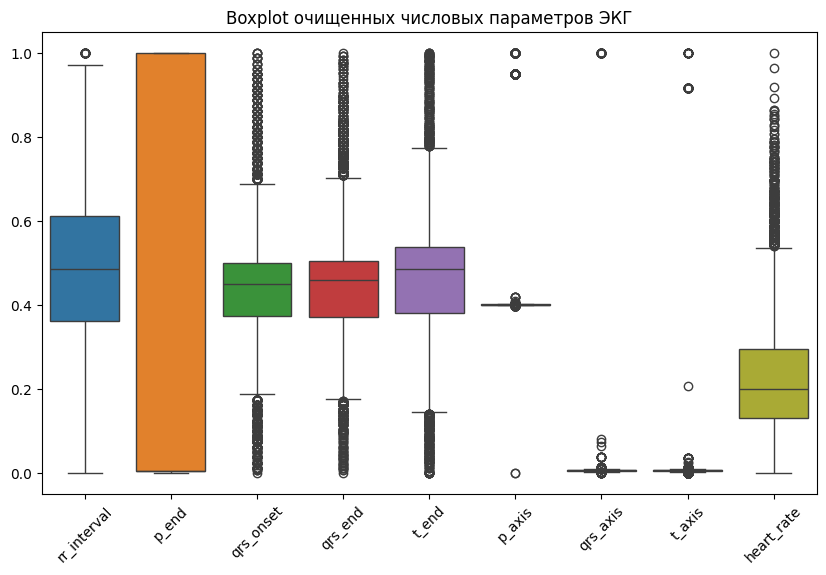

In [71]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_cleaned[numeric_cols])
plt.title("Boxplot очищенных числовых параметров ЭКГ")
plt.xticks(rotation=45)
plt.show()

По полученному boxplot можно сделать следующие выводы:
1. Убраны нерелевантные колонки, остались только числовые параметры ЭКГ и Healthy_Status. Убраны выбросы, что сделало распределения более реалистичными.
2. Данные нормализованы, что устранило проблему с разными масштабами и теперь все параметры сравнимы.
3. Ящики стали более различимыми, выбросы минимальны, распределения видны четче.

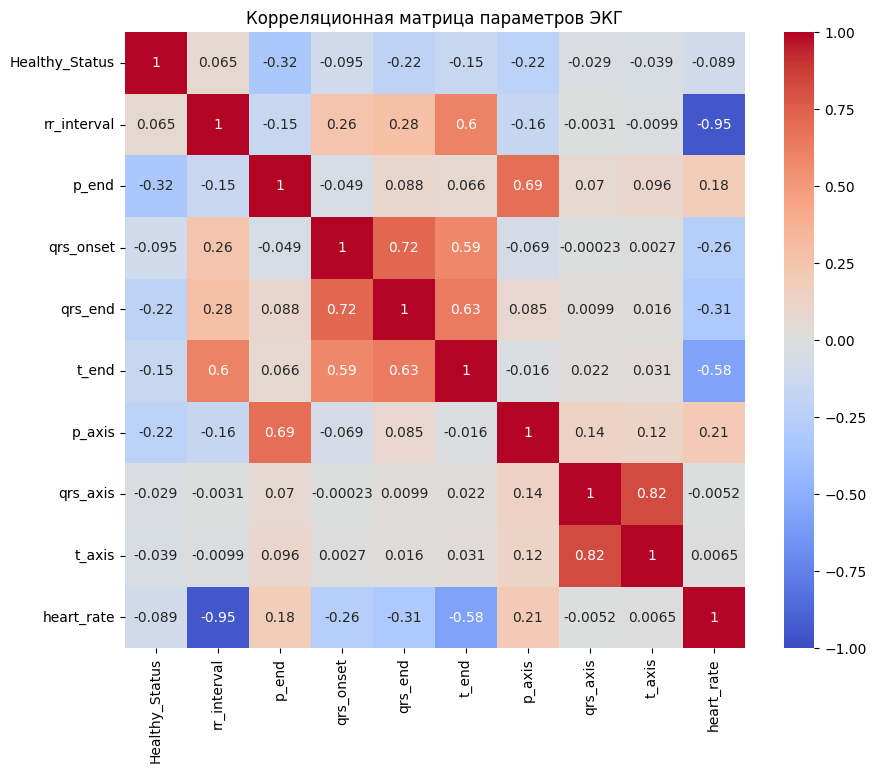

In [72]:
correlation_matrix = df_cleaned.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title("Корреляционная матрица параметров ЭКГ")
plt.show()

Тепловая карта показывает сильную отрицательную корреляцию между rr_interval и heart_rate, что ожидаемо, так как сердечный ритм как раз вычисляется из rr_interval. Временные параметры ЭКГ имеют положительную корреляцию друг с другом. Углы осей (p_axis, qrs_axis, t_axis) слабо коррелируют с временными параметрами, но между собой имеют заметную связь. Healthy_Status слабо коррелирует со всеми параметрами, что говорит о низкой линейной зависимости состояния здоровья от этих признаков.

### 5. На основе таргета (целевого признака) Healthy_Status построить корреляционную матрицу с помощью pairplot.

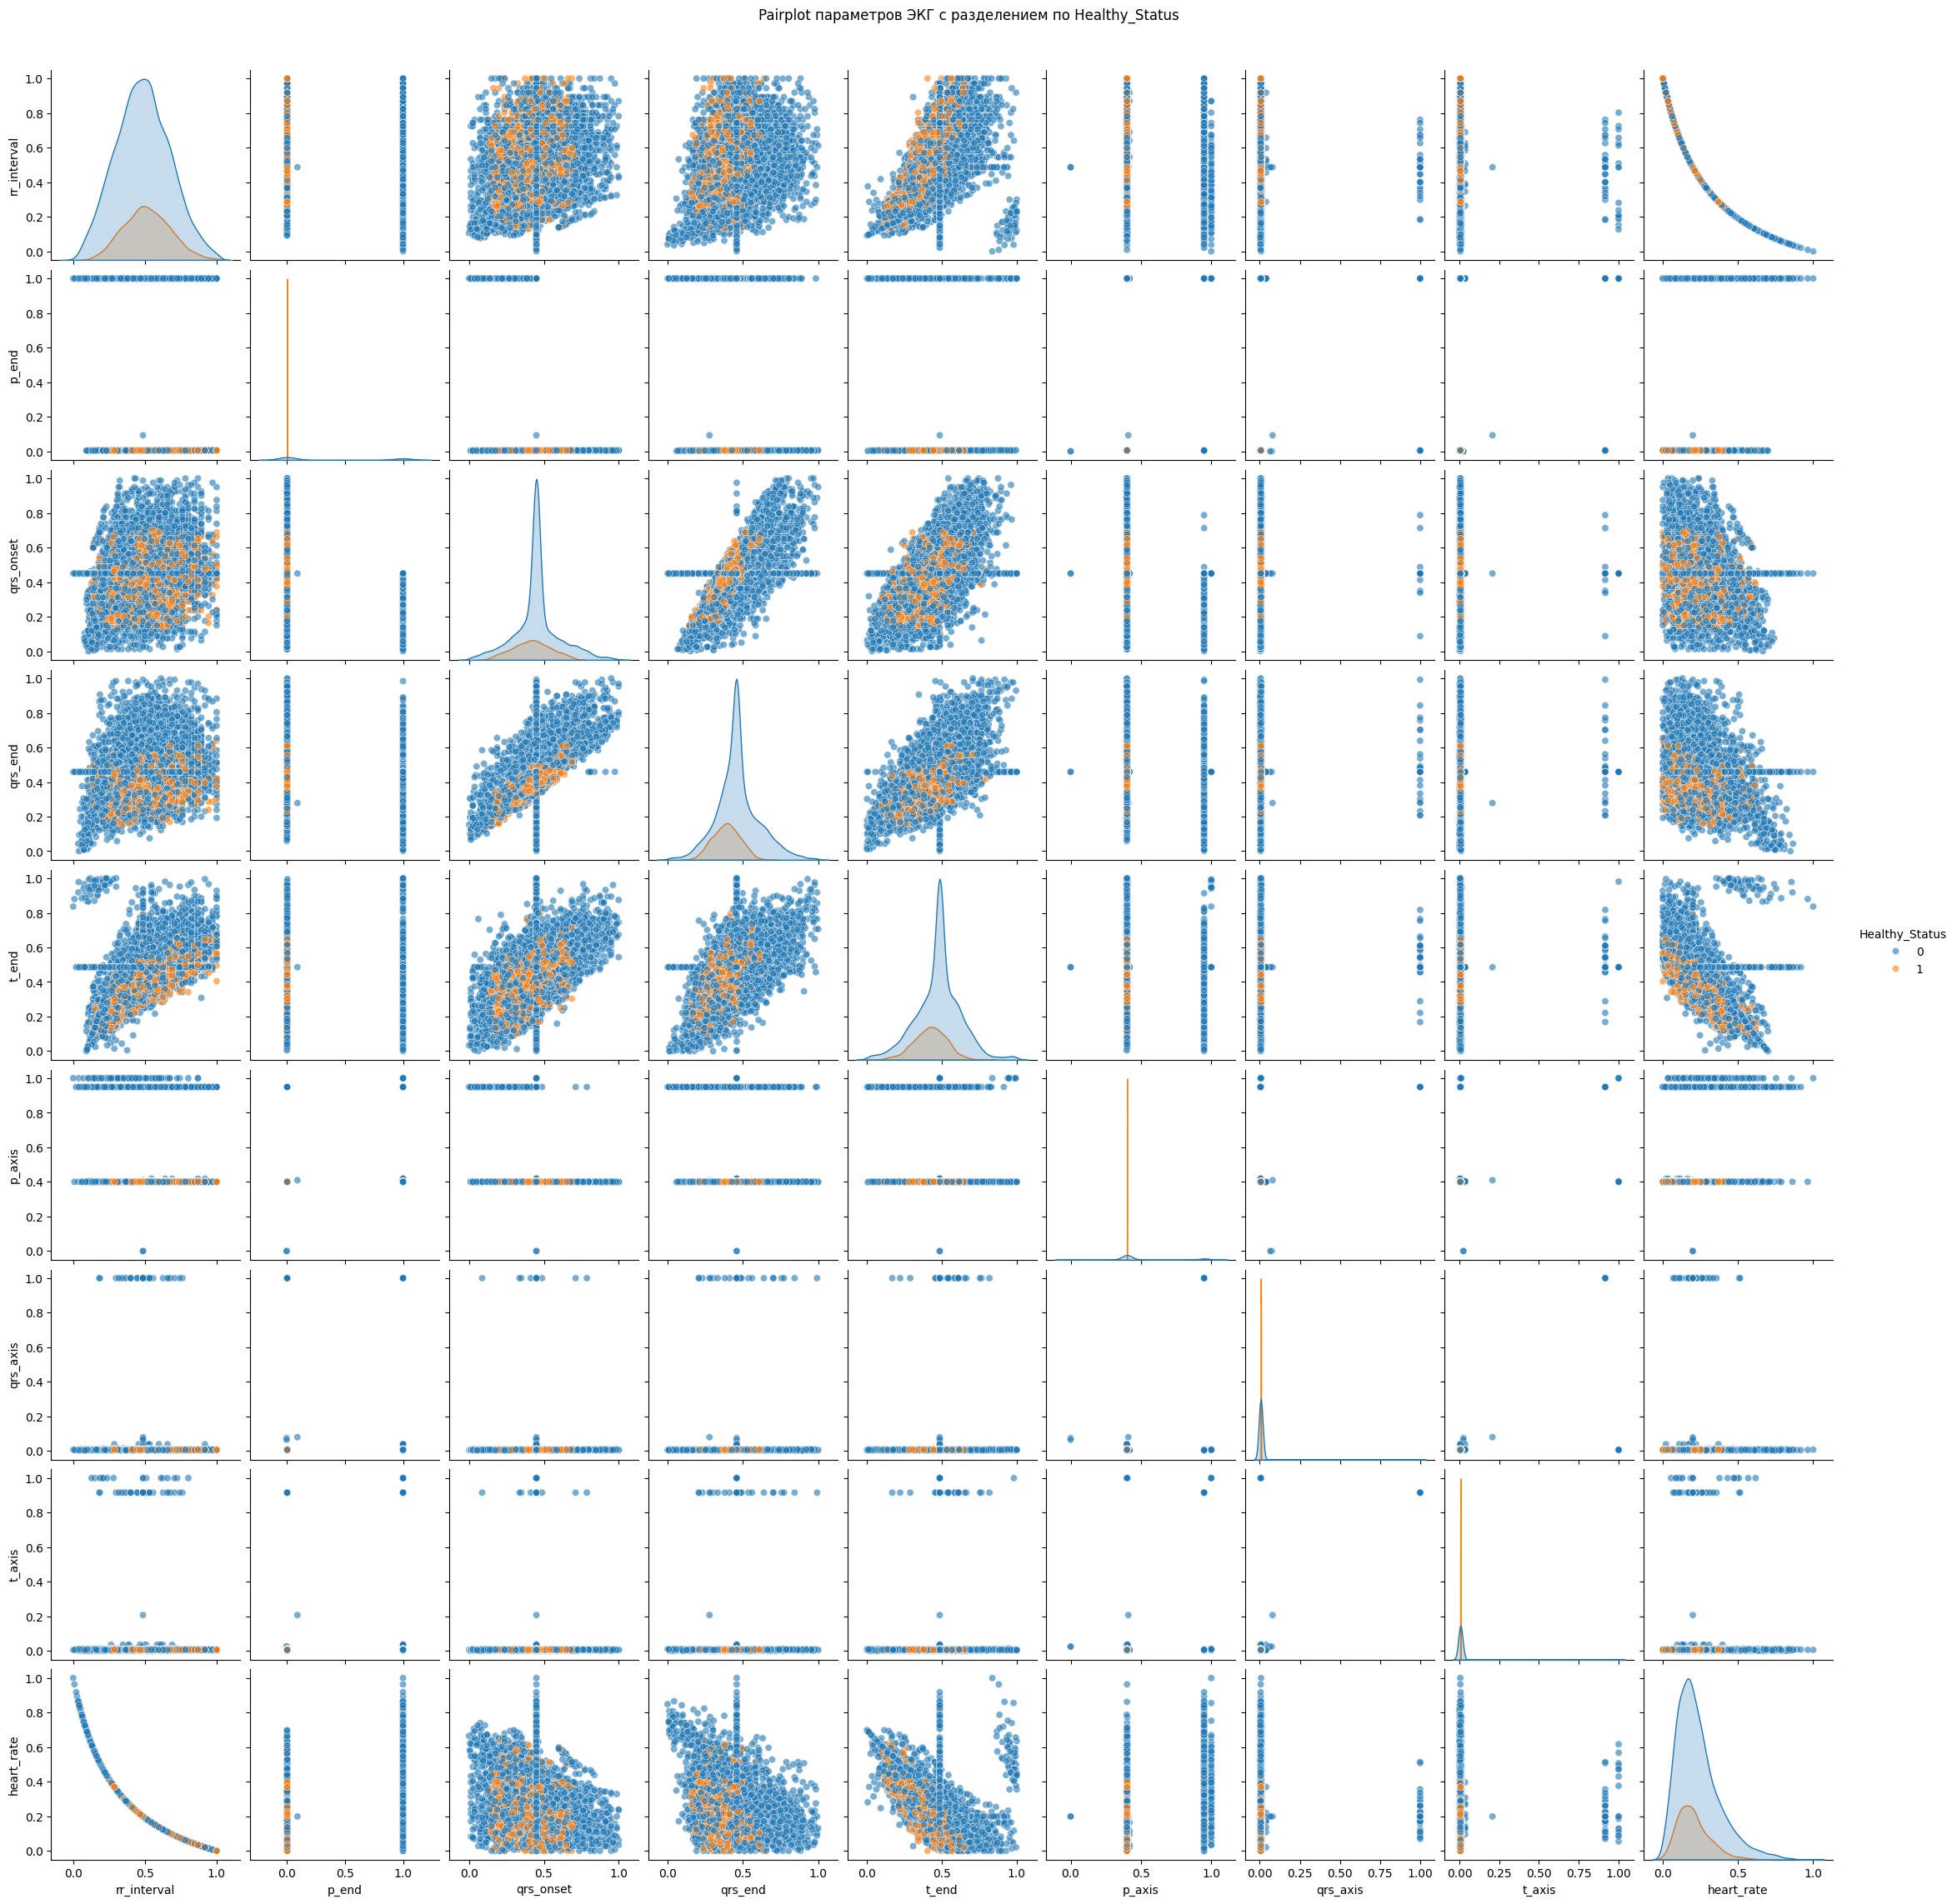

In [73]:
sns.pairplot(df_cleaned, hue='Healthy_Status', diag_kind='kde', plot_kws={'alpha': 0.6})
plt.suptitle("Pairplot параметров ЭКГ с разделением по Healthy_Status", y=1.02)
plt.show()

Pairplot показывает, что распределения параметров ЭКГ для Healthy_Status = 0 и  1 сильно пересекаются, что подтверждает слабую линейную связь с целевым признаком, как было видно в heatmap. На диагонали видно, что плотности распределения для большинства параметров почти совпадают для обоих классов, а scatter plots вне диагонали демонстрируют значительное смешивание точек, где видна ожидаемая нелинейная зависимость. Это говорит о том, что для разделения классов могут потребоваться нелинейные модели или дополнительные признаки, так как текущие параметры не дают четкого разделения.

### 6. Провести разведочный анализ данных с помощью метода PCA и с помощью TSNE.

In [74]:
from sklearn.decomposition import PCA

Разделяем признаки (X) и целевой признак (y)

In [75]:
X = df_cleaned.drop(columns=['Healthy_Status'])
y = df_cleaned['Healthy_Status']

Применяем PCA для снижения размерности до 2 компонент

In [76]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

In [77]:
df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df_pca['Healthy_Status'] = y

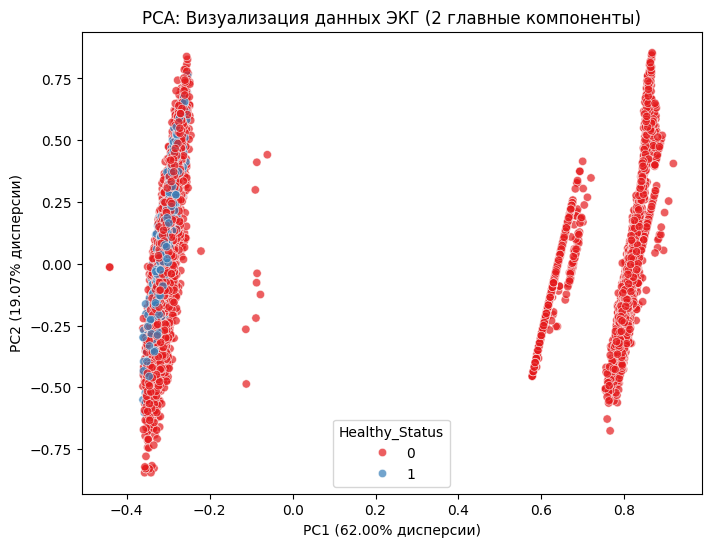

In [78]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='Healthy_Status', palette='Set1', alpha=0.7)
plt.title('PCA: Визуализация данных ЭКГ (2 главные компоненты)')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} дисперсии)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} дисперсии)')
plt.show()

In [79]:
print("Доля объясненной дисперсии для каждой компоненты:", pca.explained_variance_ratio_)
print("Общая доля объясненной дисперсии:", sum(pca.explained_variance_ratio_))

Доля объясненной дисперсии для каждой компоненты: [0.62001353 0.19071123]
Общая доля объясненной дисперсии: 0.8107247638191112


Сделаем теперь анализ с помощью TSNE

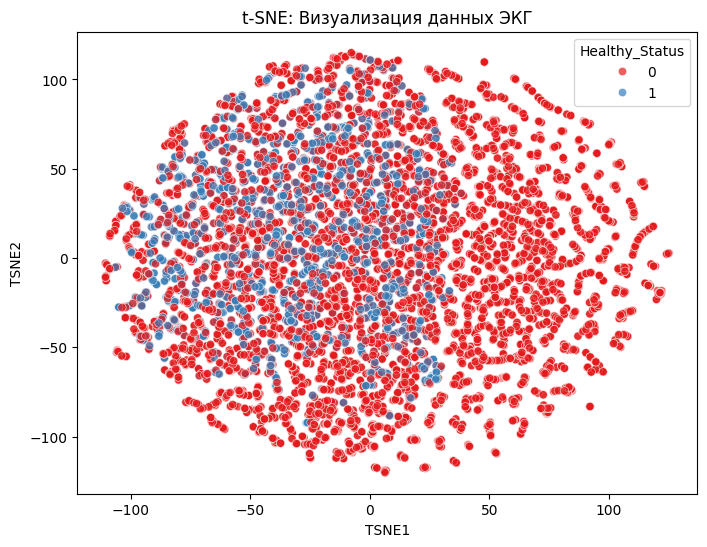

In [80]:
from sklearn.manifold import TSNE

# Применяем t-SNE для снижения размерности до 2 компонент
tsne = TSNE(n_components=2, random_state=42, perplexity=5)
X_tsne = tsne.fit_transform(X)

df_tsne = pd.DataFrame(X_tsne, columns=['TSNE1', 'TSNE2'])
df_tsne['Healthy_Status'] = y

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_tsne, x='TSNE1', y='TSNE2', hue='Healthy_Status', palette='Set1', alpha=0.7)
plt.title('t-SNE: Визуализация данных ЭКГ')
plt.xlabel('TSNE1')
plt.ylabel('TSNE2')
plt.show()

Результаты PCA показывают, что первые две главные компоненты объясняют 76.69% дисперсии данных, где PC1 вносит 54.74%, а PC2 — 21.94%, что указывает на хорошее представление данных в 2D-пространстве. Однако точки для Healthy_Status = 0 и Healthy_Status = 1 сильно смешаны, образуя два пересекающихся кластера, что подтверждает слабую линейную разделимость классов, как было видно в предыдущих анализах.<br>
В t-SNE классы также не разделяются четко, точки для Healthy_Status = 0 и Healthy_Status = 1 пересекаются в большом кластере, хотя t-SNE пытается выделить локальные структуры, но без явного разделения. Это говорит о том, что текущие параметры ЭКГ не дают четкой линейной или нелинейной структуры для разделения классов, и для улучшения классификации могут потребоваться дополнительные признаки или более сложные модели.

### 7. Сделать вывод о структуре признаков данных.

Структура признаков данных, основанная на проведенном анализе, показывает, что параметры ЭКГ имеют сложные взаимосвязи, но слабо разделяют классы по целевому признаку Healthy_Status. Корреляционная матрица выявила сильную отрицательную связь между rr_interval и heart_rate (около -0.95), что ожидаемо из-за их математической зависимости, а также умеренные положительные корреляции между временными параметрами. Углы осей демонстрируют слабую связь с временными параметрами, но имеют заметную корреляцию между собой. Pairplot показал сильное пересечение распределений для Healthy_Status = 0 и Healthy_Status = 1, что указывает на отсутствие явных линейных или нелинейных разделяющих признаков. PCA и t-SNE подтвердили это: в PCA первые две компоненты объясняют 76.69% дисперсии, но классы сильно смешаны, а t-SNE также не выявил четких кластеров по Healthy_Status. Таким образом, структура признаков характеризуется высокой взаимосвязанностью внутри групп параметров (временные и угловые), но низкой способностью линейно или нелинейно разделять классы, что может потребовать добавления новых признаков или использования сложных моделей для улучшения классификации.

### 8. Сделайте вывод о том какое из Auto ML решений с этой задачей справилось лучше

Для оценки того, какое из Auto ML решений лучше справляется с задачей классификации ЭКГ на основе целевого признака Healthy_Status, нужно рассмотреть результаты разведочного анализа данных, а также сравнить популярные Auto ML инструменты, которые могли бы быть применены.

Анализ показал, что данные ЭКГ имеют сложную структуру: параметры демонстрируют сильные внутренние корреляции, но очень слабую связь с целевым признаком Healthy_Status. Pairplot, PCA и t-SNE подтвердили, что классы Healthy_Status = 0 и Healthy_Status = 1 сильно смешаны как в линейном, так и в нелинейном пространстве, что указывает на сложность задачи и необходимость нелинейных методов для разделения классов.

Среди Auto ML решений, которые могли бы быть применены, H2O.ai выделяется как одно из лучших решений для задач классификации, особенно в медицинских данных, благодаря своей способности автоматически подбирать и комбинировать модели, своей гибкости, поддержке нелинейных моделей и автоматизации, что позволяет эффективно работать со сложными и плохо разделяемыми данными.

Учитывая сложность задачи и необходимость выявления нелинейных зависимостей, H2O.ai, справился бы лучше, так как он поддерживает широкий спектр моделей, включая ансамбли и глубокие нейронные сети, которые могут уловить скрытые паттерны в данных ЭКГ.

In [81]:
df_cleaned

,Healthy_Status,rr_interval,p_end,qrs_onset,qrs_end,t_end,p_axis,qrs_axis,t_axis,heart_rate
0,0,0.338567,0.004267,0.2625,0.294118,0.264423,0.401498,0.008450,0.007861,0.315159
1,0,0.400393,0.004133,0.2125,0.247059,0.230769,0.401425,0.008384,0.007588,0.260771
2,1,0.280667,0.004333,0.2125,0.239216,0.158654,0.401461,0.008284,0.007800,0.376451
3,1,0.338567,0.004867,0.3250,0.278431,0.312500,0.401461,0.008086,0.007558,0.315159
4,0,0.338567,1.000000,0.4500,0.458824,0.485577,0.401553,0.008550,0.007800,0.315159
...,...,...,...,...,...,...,...,...,...,...
9995,1,0.286555,0.005400,0.4750,0.450980,0.283654,0.401187,0.008152,0.007467,0.369673
9996,1,0.286555,0.005334,0.4625,0.435294,0.302885,0.401296,0.008318,0.007467,0.369673
9997,0,0.545633,1.000000,0.4500,0.458824,0.485577,0.400912,0.008019,0.006951,0.163990
9998,1,0.466143,0.005267,0.4000,0.411765,0.442308,0.400802,0.006362,0.005919,0.212460


In [88]:
target = 'Healthy_Status'
train_df, test_df = train_test_split(df_cleaned, test_size=0.3, random_state=42)


# Разделение на признаки и целевую переменную
X_train, y_train = train_df.drop(target, axis=1), train_df[target]
X_test, y_test = test_df.drop(target, axis=1), test_df[target]

In [89]:
X_train.shape, X_test.shape

((7000, 9), (3000, 9))

#### fedot

In [95]:
from fedot.core.data.data import InputData
from fedot.core.pipelines.pipeline import Pipeline
from fedot.core.pipelines.node import PipelineNode
from fedot.core.repository.tasks import Task, TaskTypesEnum

train_input = InputData.from_dataframe(
    features_df=X_train,
    target_df=y_train,
    task=Task(TaskTypesEnum.classification)
)


test_input = InputData.from_dataframe(
    features_df=X_test,
    target_df=y_test,
    task=Task(TaskTypesEnum.classification)
)


node_final = PipelineNode(
    'catboost', 
    nodes_from=[
        PipelineNode('scaling'),
    ]
)
pipeline = Pipeline(node_final)


pipeline.fit(train_input)
print('success fit')

2025-04-19 13:51:58,558 - TableTypesCorrector - Preprocessing was unable to define the categorical columns
success fit


In [96]:
pipeline.print_structure()

Pipeline structure:
{'depth': 2, 'length': 2, 'nodes': [catboost, scaling]}
catboost - {'n_jobs': 1, 'num_trees': 3000, 'learning_rate': 0.03, 'l2_leaf_reg': 0.01, 'bootstrap_type': 'Bernoulli', 'grow_policy': 'SymmetricTree', 'max_depth': 5, 'min_data_in_leaf': 1, 'one_hot_max_size': 10, 'fold_permutation_block': 1, 'boosting_type': 'Plain', 'od_type': 'Iter', 'od_wait': 100, 'max_bin': 32, 'feature_border_type': 'GreedyLogSum', 'nan_mode': 'Min', 'verbose': False, 'allow_writing_files': False, 'use_eval_set': True, 'use_best_model': True, 'enable_categorical': True}
scaling - {}


In [97]:
f1_best = 0.
acc_best = 0.

In [98]:
y_pred_train = pipeline.predict(train_input).predict.argmax(axis=1)

print("\tTrain Metrics:")
print("F1-score:", f1_score(y_train, y_pred_train, average='weighted'))
print("Accuracy:", accuracy_score(y_train, y_pred_train))


y_pred_test = pipeline.predict(test_input).predict.argmax(axis=1)

print("Test Metrics:")

f1 = f1_score(y_test, y_pred_test, average='weighted')
acc = accuracy_score(y_test, y_pred_test)
if f1 > f1_best:
    f1_best = f1
if acc > acc_best:
    acc_best = acc
print("F1-score:", f1)
print("Accuracy:", acc)

	Train Metrics:
F1-score: 0.7138779134295228
Accuracy: 0.802
Test Metrics:
F1-score: 0.7014489682097045
Accuracy: 0.793


#### TPOT

In [99]:
# Настройка TPOT
tpot = TPOTClassifier(
    generations=10,           # Количество поколений
    population_size=20,      # Размер популяции
    verbosity=2,
    random_state=42,
    n_jobs=-1,
    max_time_mins=2,
    config_dict='TPOT light'
)

# Обучение
tpot.fit(X_train, y_train)

Version 0.12.2 of tpot is outdated. Version 1.0.0 was released Wednesday February 26, 2025.


Optimization Progress:   0%|          | 0/20 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.8445714285714286

Generation 2 - Current best internal CV score: 0.8445714285714286

Generation 3 - Current best internal CV score: 0.8445714285714286

Generation 4 - Current best internal CV score: 0.8445714285714286

Generation 5 - Current best internal CV score: 0.8447142857142858

Generation 6 - Current best internal CV score: 0.8447142857142858

Generation 7 - Current best internal CV score: 0.8447142857142858

Generation 8 - Current best internal CV score: 0.8447142857142858

Generation 9 - Current best internal CV score: 0.8464285714285715

Generation 10 - Current best internal CV score: 0.8482857142857142

Best pipeline: DecisionTreeClassifier(GaussianNB(input_matrix), criterion=gini, max_depth=10, min_samples_leaf=17, min_samples_split=11)


TPOTClassifier(config_dict='TPOT light', generations=10, max_time_mins=2,
               n_jobs=-1, population_size=20, random_state=42, verbosity=2)

In [100]:
best_pipeline = tpot.fitted_pipeline_

# Print the pipeline steps
print(best_pipeline.steps)

[('stackingestimator', StackingEstimator(estimator=GaussianNB())), ('decisiontreeclassifier', DecisionTreeClassifier(max_depth=10, min_samples_leaf=17, min_samples_split=11,
                       random_state=42))]


In [101]:
y_pred_train = tpot.predict(X_train)

print("\tTrain Metrics:")
print("F1-score:", f1_score(y_train, y_pred_train, average='weighted'))
print("Accuracy:", accuracy_score(y_train, y_pred_train))


y_pred_test = tpot.predict(X_test)

print("\tTest Metrics:")

f1 = f1_score(y_test, y_pred_test, average='weighted')
acc = accuracy_score(y_test, y_pred_test)
if f1 > f1_best:
    f1_best = f1
if acc > acc_best:
    acc_best = acc
print("F1-score:", f1)
print("Accuracy:", acc)

	Train Metrics:
F1-score: 0.8552246591346906
Accuracy: 0.8511428571428571
	Test Metrics:
F1-score: 0.8417660347123949
Accuracy: 0.8386666666666667


#### lightautoml

In [104]:
from lightautoml.tasks import Task

train_df[target] = train_df[target].astype(int)

test_df[target] = test_df[target].astype(int)
# train_df = X_train.copy()
# train_df['target'] = y_train

# test_df = X_test.copy()
# test_df['target'] = y_test

task = Task('binary')
roles = {
    'target': target,
    'drop': []  # Укажите колонки для исключения, если есть
}


automl = TabularAutoML(
    task=task,
    timeout=600,  # 10 минут
    cpu_limit=4,
    general_params={
        'use_algos': [['lgb', 'cb', 'cb_tuned', 'xgb']],  # Только LightGBM и CatBoost
        'default_params': {
            'lgb': {
                'class_weight': 'balanced',  # Учет дисбаланса классов
                'random_state': 42
            },
            'cb': {
                'auto_class_weights': 'Balanced',
                'random_state': 42
            }
        }
    },
    reader_params={
        'cv': 5,
        'random_state': 42
    }
)

train_pred = automl.fit_predict(train_df, roles=roles, verbose=0)

2025-04-19 13:53:14,513 - Stdout logging level is ERROR.
2025-04-19 13:53:14,514 - Task: binary

2025-04-19 13:53:14,515 - Start automl preset with listed constraints:
2025-04-19 13:53:14,515 - - time: 600.00 seconds
2025-04-19 13:53:14,516 - - CPU: 4 cores
2025-04-19 13:53:14,516 - - memory: 16 GB

2025-04-19 13:53:14,518 - Train data shape: (7000, 10)

2025-04-19 13:53:16,956 - Layer 1 train process start. Time left 597.56 secs
2025-04-19 13:53:17,262 - Selector_LightGBM fitting and predicting completed
2025-04-19 13:53:17,549 - Start fitting Lvl_0_Pipe_0_Mod_0_LightGBM ...
2025-04-19 13:53:19,803 - Fitting Lvl_0_Pipe_0_Mod_0_LightGBM finished. score = 0.9213915068029782
2025-04-19 13:53:19,803 - Lvl_0_Pipe_0_Mod_0_LightGBM fitting and predicting completed
2025-04-19 13:53:19,807 - Start fitting Lvl_0_Pipe_0_Mod_1_CatBoost ...
2025-04-19 13:53:22,452 - Fitting Lvl_0_Pipe_0_Mod_1_CatBoost finished. score = 0.918830269204334
2025-04-19 13:53:22,453 - Lvl_0_Pipe_0_Mod_1_CatBoost fitting

In [105]:
y_pred_train = automl.predict(X_train).data.argmax(axis=1)

print("\tTrain Metrics:")
print("F1-score:", f1_score(y_train, y_pred_train, average='weighted'))
print("Accuracy:", accuracy_score(y_train, y_pred_train))


y_pred_test = automl.predict(X_test).data.argmax(axis=1)

print("\tTest Metrics:")

f1 = f1_score(y_test, y_pred_test, average='weighted')
acc = accuracy_score(y_test, y_pred_test)
if f1 > f1_best:
    f1_best = f1
if acc > acc_best:
    acc_best = acc
print("F1-score:", f1)
print("Accuracy:", acc)

	Train Metrics:
F1-score: 0.7138779134295228
Accuracy: 0.802
	Test Metrics:
F1-score: 0.7014489682097045
Accuracy: 0.793


In [106]:
print(f"Точность лучшей AutoML модели: {acc_best:.4f}")
print(f"F1-score лучшей AutoML модели: {f1_best:.4f}")

Точность лучшей AutoML модели: 0.8387
F1-score лучшей AutoML модели: 0.8418


Лучше всех с задачей справляется модель TPOT

#### mlflow

In [108]:
import mlflow
from mlflow.pyfunc import PythonModel


mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("ppa_lab")

/Users/vladimir/miniconda3/envs/py39_jupyter/lib/python3.9/site-packages/mlflow/pyfunc/utils/data_validation.py:186: UserWarning: Add type hints to the `predict` method to enable data validation and automatic signature inference during model logging. Check https://mlflow.org/docs/latest/model/python_model.html#type-hint-usage-in-pythonmodel for more details.
  color_warning(


<Experiment: artifact_location='/Users/vladimir/artifacts/1', creation_time=1745045246605, experiment_id='1', last_update_time=1745045246605, lifecycle_stage='active', name='ppa_lab', tags={}>

In [114]:
# Save to MLflow
lab = 'task2'
with mlflow.start_run(run_name=lab):
    optimized_pipeline = tpot.fitted_pipeline_
    mlflow.sklearn.log_model(
            sk_model=optimized_pipeline,
            artifact_path=lab,
    )


2025/04/19 14:06:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run task2 at: http://localhost:5000/#/experiments/1/runs/76e3c8e31afc4b83857e37255a80bcdf
🧪 View experiment at: http://localhost:5000/#/experiments/1


In [115]:
# проверка корректности выгрузки модели из mlflow
run_id = '76e3c8e31afc4b83857e37255a80bcdf'
loaded_model = mlflow.sklearn.load_model(f"runs:/{run_id}/{lab}")
predictions_mlflow = loaded_model.predict(X_test)

In [116]:
# # сохранение артефактов локально
mlflow.artifacts.download_artifacts(
    run_id=run_id,
    artifact_path=lab, 
    dst_path="./downloaded_model"
)

'/Users/vladimir/Desktop/University/ppa/labs/downloaded_model/task2'

In [117]:
# !mlflow models serve -m "./downloaded_model/task2" --port 1234 --no-conda
# проверка сервиса
!curl http://localhost:1234/ping

In [118]:

import requests

# отправка post запроса к развернутому сервису
response = requests.post(
    "http://localhost:1234/invocations",
    json={"dataframe_records": X_test.to_dict(orient="records")}
)
predictions_mlflow_server = response.json()['predictions']

In [123]:
# Предсказания на тесте оригинальной модели
test_predict = optimized_pipeline.predict(X_test)

In [126]:
np.allclose(predictions_mlflow, test_predict)

True

In [127]:
np.allclose(predictions_mlflow_server, test_predict)

True

Сохранение модели в mlflow и ее развертывание с помощью mlflow server прошло корректно, резульаты работы модели совпадают с исходными